## Introduction

This script demonstrates how you can use a RNN-based model to detect anomalies in timeseries data.

## Setup

In [1]:
import json
import os
import random

import numpy as np
import pandas as pd
import sklearn
from celluloid import Camera
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm, trange
from evaluator import evaluate, compute_threshold
from dataloader import loader

# from sklearn.metrics import confusion_matrix

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

2023-02-12 02:39:20.203644: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Load the data

We will use the SMAP data sets for training and testing.

You can find raw data in https://s3-us-west-2.amazonaws.com/telemanom/data.ziphttps://s3-us-west-2.amazonaws.com/telemanom/data.zip

I used preprocessed datasets with 25 dimensions.

You can find preprocessed data in https://drive.google.com/drive/folders/1gisthCoE-RrKJ0j3KPV7xiibhHWT9qRmhttps://drive.google.com/drive/folders/1gisthCoE-RrKJ0j3KPV7xiibhHWT9qRm

In [2]:
df_train, df_test, df_test_label = loader(dataset="UCR")

## Prepare training data


In [3]:
from sklearn.preprocessing import StandardScaler

# Skip data normalization because SMAP datas were already normalized.
df_train = df_train.fillna(method="ffill")
scaler = StandardScaler()
scaler.fit(df_train)
df_training_value = pd.DataFrame(scaler.transform(df_train))
print("Number of training samples:", len(df_training_value))

Number of training samples: 35000


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [4]:
TIME_STEPS = 50

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
# x_valid = create_sequences(df_validating_value.values)
print("Training input shape: ", x_train.shape)
# print("Validating input shape: ", x_valid.shape)
NUM_OF_FEATURES = x_train.shape[-1]

Training input shape:  (34951, 50, 1)


## Build a model


In [5]:
model = keras.Sequential(
    [
        layers.InputLayer(input_shape=(x_train.shape[1], x_train.shape[2])),
        layers.GRU(64, return_sequences=True),
        layers.GRU(32),
        layers.RepeatVector(x_train.shape[1]),
        layers.GRU(32, return_sequences=True),
        layers.GRU(64),
        layers.Dense(x_train.shape[1] * x_train.shape[2]),
        layers.Reshape([x_train.shape[1], x_train.shape[2]]),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

2023-02-12 02:39:21.143869: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-12 02:39:21.179933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1f:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-02-12 02:39:21.179973: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-12 02:39:21.182409: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-12 02:39:21.182480: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-12 02:39:21.183245: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50, 64)            12864     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 50, 32)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 50, 32)            6336      
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dense (Dense)                (None, 50)                3250      
_________________________________________________________________
reshape (Reshape)            (None, 50, 1)             0

## Train the model


In [6]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

Epoch 1/50


2023-02-12 02:39:22.292421: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-12 02:39:22.311730: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz
2023-02-12 02:39:25.329895: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-12 02:39:25.948064: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-02-12 02:39:26.130744: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-12 02:39:26.780311: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-12 02:39:26.780395: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


219/219 [==============================] - 9s 21ms/step - loss: 0.3350 - val_loss: 0.1488
Epoch 2/50
219/219 [==============================] - 4s 18ms/step - loss: 0.0502 - val_loss: 0.0953
Epoch 3/50
219/219 [==============================] - 4s 17ms/step - loss: 0.0366 - val_loss: 0.0780
Epoch 4/50
219/219 [==============================] - 4s 18ms/step - loss: 0.0308 - val_loss: 0.0695
Epoch 5/50
219/219 [==============================] - 4s 18ms/step - loss: 0.0278 - val_loss: 0.0623
Epoch 6/50
219/219 [==============================] - 4s 18ms/step - loss: 0.0247 - val_loss: 0.0569
Epoch 7/50
219/219 [==============================] - 4s 18ms/step - loss: 0.0229 - val_loss: 0.0534
Epoch 8/50
219/219 [==============================] - 4s 17ms/step - loss: 0.0220 - val_loss: 0.0517
Epoch 9/50
219/219 [==============================] - 4s 18ms/step - loss: 0.0210 - val_loss: 0.0502
Epoch 10/50
219/219 [==============================] - 4s 17ms/step - loss: 0.0195 - val_loss: 0.0500


Let's plot training and validation loss to see how the training went.

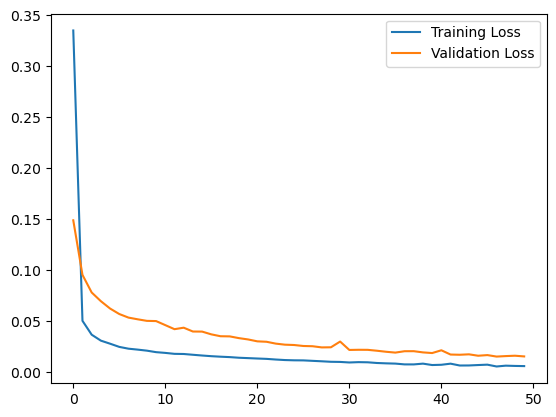

In [7]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies


In [8]:
x_train_pred = model.predict(x_train)

In [9]:
# print(f'abs mean threshold: {compute_threshold(x_train, x_train_pred, option="abs_mean")}')
# print(f'abs median threshold: {compute_threshold(x_train, x_train_pred, option="abs_median")}')
# print(f'square mean threshold: {compute_threshold(x_train, x_train_pred, option="square_mean")}')
# print(f'square median threshold: {compute_threshold(x_train, x_train_pred, option="square_median")}')

# Choose the lowest loss of the anomaly datas((# of anomalies)th) as threshold by using rank option
threshold = compute_threshold(x_train, x_train_pred, option="abs_max")
print(f'rank threshold: {threshold}')

rank threshold: 0.1124604344367981


### Prepare test data

In [10]:
df_test_value = pd.DataFrame(scaler.transform(df_test))

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

# Detect all the samples which are anomalies.
# anomalies = test_mae_loss > threshold
anomalies = np.sum(test_mae_loss, axis=1) > threshold

Test input shape:  (44746, 50, 1)


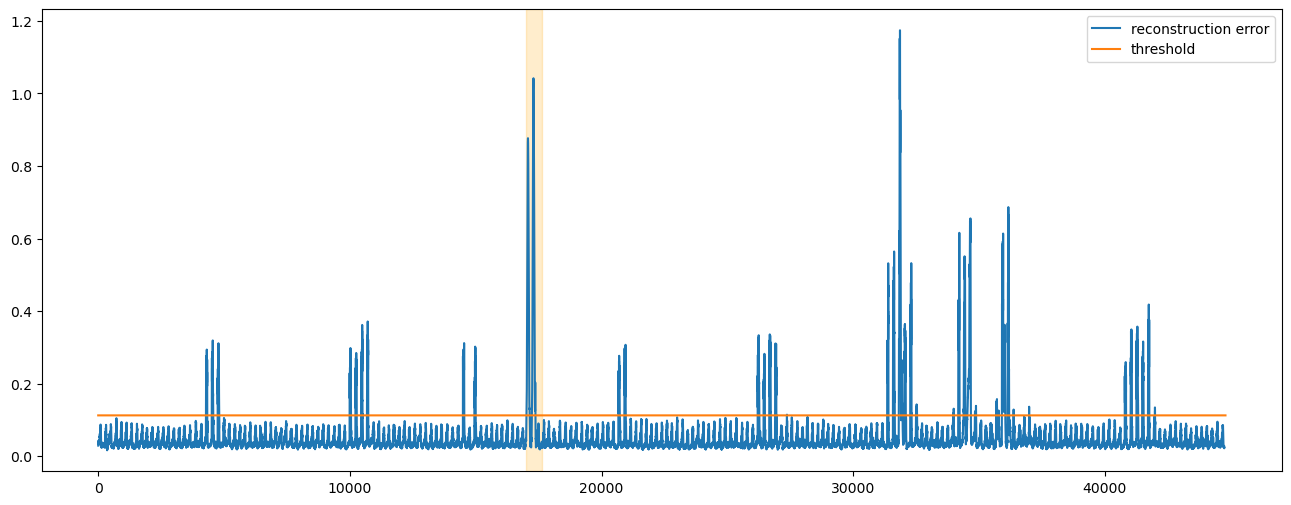

In [11]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

labels = df_test_label['label'].values.tolist()
dates = df_test.index


pd.DataFrame(np.sum(test_mae_loss, axis=1)).plot(ax=ax)
pd.DataFrame([threshold]*len(df_test)).plot(ax=ax)
ax.legend(["reconstruction error", "threshold"], loc="upper right")


temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label==True:
            ax.axvspan(temp_start, temp_date, alpha=0.2, color="orange")
        temp_start = xc
        temp_label = value
    temp_date = xc
if temp_label==True:
    ax.axvspan(temp_start, xc, alpha=0.2, color="orange")


## Predict & Evaluation

## #1 Set threshold by using evaluator

In [12]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalies = np.sum(test_mae_loss, axis=1) > threshold
print("Number of anomaly samples: ", np.sum(anomalies))

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.any(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
print("Number of anomalous samples: ", len(anomalous_data_indices))

Number of anomaly samples:  2350
Number of anomalous samples:  4381


In [13]:
from sklearn.metrics import classification_report

test_pred = np.zeros(len(df_test))
test_label = df_test_label['label']
test_pred[anomalous_data_indices] = 1

accuracy = (np.sum(test_pred == test_label)) / len(test_label)
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred)
recall = (np.sum(test_pred * test_label)) / np.sum(test_label)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")

accuracy: 90.42%
precision: 8.10%
recall: 57.17%
f1: 14.19%


### #2 we could find the threshold with highest f1 score by calculating all cases 


In [14]:
from evaluator import evaluate

scores = evaluate(x_test, x_test_pred, df_test_label['label'], n=10, scoring='abs_mean')

In [15]:
print("f1:",np.max(scores['f1']))

f1: 0.10997529359533068
